### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
8. Although not forced to work exclusively in the course `conda` environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

### Fill in group number and member names:

In [8]:
NAME1 = "David Nordström"
NAME2 = "Gabriele Calzolari"
GROUP = "6"

### Check Python version

In [9]:
from platform import python_version_tuple

assert (
    python_version_tuple()[:2] == ("3", "11")
), "You are not running Python 3.11. Make sure to run Python through the course Conda environment."

# HA1 - Cats and dogs

<img src="https://cdn.pixabay.com/photo/2015/05/20/10/03/cat-and-dog-775116_960_720.jpg" alt="Image of cats and dogs" style="width: 500px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colour images of dogs and cats. Our goal with this assignment will be to create a classifier that can discriminate between cats or dogs.

The goal is to make sure that you all can independently create, train and evaluate a model using a popular deep learning framework. A secondary goal is also to expose you to GPU computing, either your own, by using a server/cluster, or via a cloud computing service. The focus is on implementing the models, and much of the surrounding code is provided for you. You are expected to understand the provided code.

## Using your GPU

### Strong recommendation:
In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) on your own computer (these tasks can be solved on the CPU). Remaining tasks (4-6) will require GPU computing. While you are free to use any GPU resource, we recommend getting familiar with using a server, cluster, or cloud computing service.


### Working efficiently:
Training for several epochs just to have your code break at the last validation step is incredibly frustrating and inefficient. Good practice is to first test long training runs with a much simpler dry-run: a single epoch, a few batches etc.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance. When experimenting, a single epoch is often enough to tell whether your model setup has improved or not.


**IMPORTANT NOTES:**
- Some cells contain compiled tests. For them to work propery, make sure to keep variable names. For example, if you are asked to create a training dataset, and `train_dataset` is passed to the test, then you should complete the task by updating `train_dataset` variable in your code. But, of course, you can create auxiliary variables.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [8]:
from utils.tests import ha1_tests
# YOUR CODE HERE
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
from pathlib import Path
import torchvision

---
## 1. Loading the data and preprocessing

In this part we will set up the data used in this assignment. You need to download it, then we'll walk you through how to make a custom Pytorch dataset abstraction. The abstraction enables you to visualise and play around with the image data and to finally create data loaders, which are necessary for the training.

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats/data) and download the data from there. You should download both the test and train folders together in one zip file (there is a `Download all` button at the bottom of the page). Unfortunately, you need to create a Kaggle account for this.

**Only necessary for tasks 4-6**: Downloading the data to your local computer is quite straight-forward. If you have to upload the data to a cloud/server instance that might be a bit more tricky. There are a few ways to do it:

 - Jupyter Notebook upload function. When starting the notebook server with the command `jupyter notebook` you are directed to a main page. In the top right corner there is an upload button.
 - Using [`scp`](https://linuxize.com/post/how-to-use-scp-command-to-securely-transfer-files/) to copy files via an ssh connection.
 - Using the [Kaggle CLI](https://github.com/Kaggle/kaggle-api). We have added it to the conda environment.

To begin with, download the data to your local computer and create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      cats        dogs       cats        dogs       cats        dogs       cats        dogs


The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`.
This is just a convenient way of having a smaller dataset to play with for faster prototyping.

We provide you a notebook that shows how to achieve this folder structure (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

**(1 point)**

For the smaller dataset, we advise you to use 70% of the data as training data (and thereby the remaining 30% for validation data). However, for the larger dataset, you should decide how to split between training and validation.

- What percentage of the larger dataset did you decide to use for training/validation?
- Motivate your decision.

**Your answer:** We chose 20% reserved for validation and the rest for training. This is a common split and perhaps some regard should be taken to that we have quite a small dataset (so maybe more should be used for training). But 20% is likely an OK split and quite standard.

Fill in the dataset paths (to be used later by your data loaders):

In [4]:
# TODO: Change the directories accordingly
train_path = "./train"
val_path = "./val"
small_train_path = "./small_train"
small_val_path = "./small_val"
# YOUR CODE HERE

### 1.1 Dataset

To create data loaders we first need to create a dataset abstraction class. The purpose of a data loader is to efficiently provide the CPU/GPU with mini-batches of data. We now work with data complex enough to actually warrant the use of data loaders. In particular, we don't want to load all images into memory at once.

The data loader is an instance of the Pytorch [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) which wraps a class that inherits from [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), that we create ourselves.
Image classification is such a common task that Pytorch provides a ready-to-use dataset class for this task, called [`ImageFolder`](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#imagefolder).
Using this class however, is rather opaque so for your understanding we will show you how to construct a custom dataset class. If you know this method, you will be able to create a data loader for any dataset you may encounter.

We construct a class `DogsCatsData` as a subclass of `Dataset`. 
The dataset subclass holds the actual data, or at least provides access to it.
To make it work with the `DataLoader` class we need to implement two methods:

- `__getitem__(self, index)`: return the `index`'th sample, i.e. a single pair of (image, label)
- `__len__(self)`: simply return the total number of samples $N$ in the dataset.

These methods are so called Python "magic" methods, signified by the leading and closing double underscores.
They typically enable special syntax for a class: `__getitem__` enables indexing of a class, and `__len__` enables calling the `len` function:
```python
# Consider an instance `data` of a class `MyDataset` implementing `__getitem__` and `__len__`
data[10] # returns the item with index 10 in `data`
len(data) # returns the length/size of `data`
```
We will return to why these are needed in the `DataLoader` wrapping class

Now, to the actual implementation: The idea is to have the dataset class only store the filenames of the images (and the corresponding label), not the images themselves. We will find and store the filenames in the constructor. The `__getitem__` method will use the index to look up the correct filename and load it into memory.
The `__len__` method is left for you to implement.

Being able to use and understand code you have not written is an important ability. Below you are required to interact with the dataset class with a simple completion of the implementation and by extracting some data from the class. This is partly to ensure that you understand this specific class and partly to show you some tools for exploring new code.

In [5]:
from itertools import chain

from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path


class DogsCatsData(Dataset):
    def __init__(self, root, transform, dog_label=1, cat_label=0):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self._dog_label = dog_label
        self._cat_label = cat_label

        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """Collect all paths and labels

        Helper method for the constructor
        """
        # Iterator over dog filpath
        dog_paths = self._collect_imgs_sub_dir(self.root / "dogs")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        dog_paths_and_labels = map(lambda path: (path, self._dog_label), dog_paths)
        # Same for cats
        cat_paths = self._collect_imgs_sub_dir(self.root / "cats")
        cat_paths_and_labels = map(lambda path: (path, self._cat_label), cat_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(
            list(chain(dog_paths_and_labels, cat_paths_and_labels)),
            key=lambda x: x[0].stem,
        )

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.jpg")

    def get_sample_by_id(self, id_):
        """Get sample by image id

        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.

        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]

**(2 points)**

Show that you understand the implementation by creating an instance called `example_dataset` of it. Create it from the small training set.
Use the instance to:
- print the number of samples in it
- print the label of the second sample, note that this is a number (0 or 1)

In [6]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
from torchvision.transforms import Compose, ToTensor

transform = Compose([ToTensor()])
example_dataset = None
number_of_samples = None
label = None
# YOUR CODE HERE
example_dataset = DogsCatsData(small_train_path, transform)
number_of_samples = len(example_dataset)
img, label = example_dataset[1]

print(f"The number of samples is: {number_of_samples}")
print(f"The label of the second sample is: {label}")

The number of samples is: 3500
The label of the second sample is: 0


In [14]:
# Test case for `number_of_samples`
ha1_tests.test_number_of_samples(example_dataset, number_of_samples, DogsCatsData)

Test passed


In [15]:
# Test case for `label`
ha1_tests.test_label(example_dataset, label, DogsCatsData)

Test passed


It is vital to explore your data, but it can be tricky to deal with images in the tensor format.
To aid you, use the below helper function to visually inspect your images.

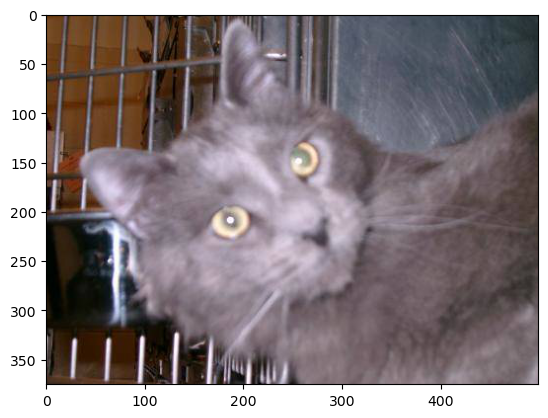

In [5]:
def display_image(axis, image_tensor):
    """Display a tensor as an image

    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """

    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError(
            "The `display_image` function expects a `torch.Tensor` "
            + "use the `ToTensor` transformation to convert the images to tensors."
        )

    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)


# Example usage
_, axis = plt.subplots()
some_random_index = 453
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, label = example_dataset[some_random_index]
display_image(axis, image_tensor)

### 1.2 Preprocessing 
The `DogsCatsData` class constructor has an argument called `transform`. It allows us to transform or preprocess all the images in a batch, from the raw image data to a more suitable format. There are multiple motivations for preprocessing:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to create a simpler optimisation problem.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit. Use the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms) to view available transforms. Extra important is the `Compose` transformation, which is a meta-transformation which composes actual ones, and the `ToTensor` transformation which is the simplest way to go from image to tensor format.


Hints:
- Revisit the `DogsCatsData` example usage to see how to use the `Compose` and `ToTensor` transformations.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned Pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial as it speeds up training. The CNN's do surprisingly well on 64x64 or even 32x32 images. Shorter training cycles give you more time to experiment! Note: The VGG network used later in this assignment is specialised for images that are 224x224.

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with a helper function to visually compare transformations side by side:

In [17]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.

    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)

    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """

    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)

    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

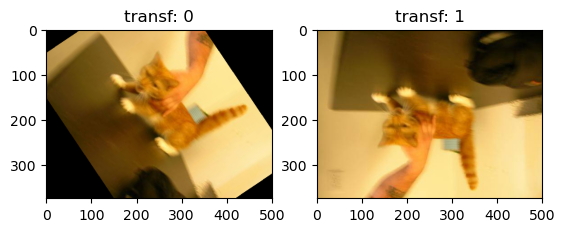

In [18]:
# Explore your dataset in this cell, you do not need to produce any results.
img_size = None
train_dataset = None

# YOUR CODE HERE
dataset_rot = DogsCatsData(train_path, Compose([
    torchvision.transforms.RandomRotation(90),
    ToTensor()]))

dataset_flip = DogsCatsData(train_path, Compose([
    torchvision.transforms.RandomVerticalFlip(1.0),
    ToTensor()]))

compare_transforms([dataset_rot, dataset_flip], 0)

**(2 points)**

Normalisation of the training data is popular in pre-processing. What is the argument or intuition for why this is a beneficial transformation?

**Your answer:** Normalization can be done for example by subtracting the mean (RGB) and std of ImageNet-1K (a common dataset). I would say the main intuition for me is that symmetrizing the range around zero with std=1.0 provides a better learning experience because a symmetric range provides a broader range of possible parameters that fit well.

### 1.3 Data loaders
With our dataset class implementation in place, creating a `DataLoader` instance is simple.

The data loader class wraps the dataset and provides a way to iterate over batches in the training loop.
To produce batches, it gets the total number of samples $N$ with the dataset's `__len__` method.
It divides the indices $1, \dots, N$ into equally sized index batches with $B$ (batch size) elements. A particular batch with pairs of image and label is created by calling the dataset's `__getitem__` method with the indices in the batch. NB: the last batch in an epoch might be smaller if $N$ is not divisible by $B$.

Create the data loaders needed for training (use the small version of the data), in the cell below.
The `DataLoader` class is documented [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) , but it's not that much to it.
You simply create a data loader with a dataset instance and some other (self-explanatory) settings:

```python
train_dataloader = DataLoader(example_dataset, batch_size=batch_size, shuffle=True)
```

**(1 point)**

Create data loaders required for training and validation.

Hints:
- The specified `batch_size` should be chosen so that you train fast but don't run out of memory. You need to figure this out empirically; start small and increase the batch size until you run out of memory. Beyond this pragmatic approach, feel free to contribute to the highly contested scientific debate about the relation between batch size and generalisation.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably.

In [23]:
batch_size = None
train_dataloader = None
val_dataloader = None

# YOUR CODE HERE
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader
batch_size = 32
img_size = 224
transform = Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    ToTensor()
])
train_dataset = DogsCatsData(train_path, transform)
val_dataset = DogsCatsData(val_path, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# For the small model
first_train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=8)
first_val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=8)

new_train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
new_val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)

In [10]:
# Test case for `train_dataloader`
ha1_tests.test_dataloader(train_dataloader)

Test passed


In [11]:
# Test case for `val_dataloader`
ha1_tests.test_dataloader(val_dataloader)

Test passed


**(0 points)**

What batch size did you use and why?

**Your answer:** We use 1024 because it is the largest multiple of two that fits on my NVIDIA GeForce RTX 3080 (10GB) for image size 224. The multiple of two thing is a little bit of a myth but also has some merit. Because a warp on a streaming multiprocessor (SM) on an NVIDIA chip contains 32 threads, people generally advice to have matrix sizes (like embedding dimensions) being a multiple of 32 as well as for batch dimension. The main reason for this is due to how tiled matrix multiplication is done and avoiding branch divergence at the edge cases (which matrices of odd shapes lead to).

For the larger model (JohnWickCNN) we use a much smaller batch size because a larger one does not fit on the GPU :)

---
## 2. Training

### 2.1 The first model

**(3 points)**

Now, it's time to create a model called `FirstCnn`. To begin with, you have to create a CNN to an exact specification. After that, you will get the chance to be more creative.

For the first model, create a network that:
- Inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)
- Implements a constructor `__init__(self, img_size)`, a `forward(self, input_batch)` method and whatever other helper methods you deem necessary. Note that a (square) image size should be a parameter in the model's constructor. While not strictly necessary, it is an acceptable way of handling varying input dim's and it is convenient for testing.
- Can handle square images of arbitrary size and arbitrary large mini-batch sizes (within memory limits, of course). You may assume that there are always three colour channels, i.e., a mini-batch will have the shape `(batch size = B, num channels = 3, img size = D, D)`
- Has layers:
    1. Two convolutional layers, each with 10 filters, kernel size = 3, stride = 1, padding = 0
    2. A single fully connected layer.
    - *Note:*
        - Related layers such as a pooling operation are optional.
        - Choose suitable activation functions.
        - Take the layers from [`torch.nn`](https://pytorch.org/docs/stable/nn.html) module, and **not** from `torch.nn.functional` module. 
- Outputs the probability of the image belonging to the class 'dog'. Technically the output should consist of `B` probabilities, one for each image in the mini-batch and so have the shape `(B,)`.

Hints:

- The subpage for [`torch.nn`](https://pytorch.org/docs/stable/nn.html) is a good place to find the layer specifics.
- Going from the last CNN layer to the final fully connected layer is not trivial. The convolutions produces feature maps which we can think of as an image with many channels, while the fully connected layer expects a row vector as input. Calculate how many output neurons the convolutions produce and use `.reshape` to make your tensor fit the fully connected layer. It is also common to see the `.view` and `.squeeze` methods to do the same thing. They basically do the same thing (apart from some differences in internal memory management) but are less transparent. *Hint within the hint:* remember that the fully connected layers expects a *batch* of 1D tensors. 


In [22]:
# class FirstCnn...
#    def __init__(self, img_size):
#       ...
#    ...

# first_model = FirstCnn(img_size)

# YOUR CODE HERE

class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super(FirstCnn, self).__init__()
        n_out = 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        out_size = (((img_size-2)//2)-2)//2
        self.fc = nn.Linear(out_size*out_size*10, n_out)
        self.final_act = nn.Sigmoid()
    def forward(self, input_batch):
        x = self.act(self.conv1(input_batch))
        x = self.pool(x)
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.view(x.size(0), -1))
        return self.final_act(x.squeeze(1))

img_size = 256
model = FirstCnn(img_size)
x = torch.randn(32, 3, img_size, img_size)
model(x)

tensor([0.5118, 0.4866, 0.5495, 0.4909, 0.5309, 0.5042, 0.5283, 0.5196, 0.5444,
        0.5326, 0.5057, 0.4989, 0.5655, 0.5357, 0.5126, 0.4881, 0.5009, 0.5088,
        0.5237, 0.5162, 0.5247, 0.4975, 0.5266, 0.5043, 0.5237, 0.5168, 0.5476,
        0.5186, 0.5436, 0.5227, 0.5052, 0.5342], grad_fn=<SigmoidBackward0>)

In [23]:
# Test case 1 for `FirstCnn`
# Note that the test takes the actual class, not an instance of it, as input.
ha1_tests.test_model(FirstCnn)

Test passed.


In [24]:
# Test case 2 for `FirstCnn`
ha1_tests.test_architecture(FirstCnn)

IndexError: arrays used as indices must be of integer (or boolean) type

**(2 points)**

You have been told that one of the benefits of CNN is that it can handle input of different sizes. Yet, you needed to know the image size in the constructor.
Explain how you made your model handle different input sizes and why it is necessary, despite it being a CNN.

**Your answer:** You can avoid this by doing something more akin to how a ViT does it (or like ConvNext architecture) where you keep the same spatial resolution throughout the network. But here I downsample the spatial resolution with the kernel size (by subtraction of 2) and by the max pooling (by integer division of 2), thus, we can simply calculate the final spatial resolution by composing these operations alongside our layers (or using nn.lazylinear lol)

### 2.2 The training loop

**(2 points)**

You have already seen quite a few training loops in the preparations. Below we provide you with an example of a basic one that you can use.
You need to provide an implementation that maps network outputs (probabilites) to hard labels.

An extra point is awarded if you provide a vectorised implementation.

In [18]:
def output_to_label(z):
    """Map network output z to a hard label {0, 1}

    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    # YOUR CODE HERE
    return z.ge(0.5).long()

In [26]:
# Test case for `output_to_label` function
ha1_tests.test_output_to_label(output_to_label)

Test passed


In [14]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

**(1 point)**

Use the training loop to train your model, using the two dataloaders you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Which `loss_fn` should you use? Think first about what is suitable for this problem, not what seems to work better empirically.
- Training on a CPU is slow and in the beginning you just want to verify that your architecture actually produces a predicition with the correct shape. Make everything you can to speed up the prototyping phase, e.g. train only for a single epoch and make the images ridiculously small.

In [29]:
loss_fn = None

# YOUR CODE HERE
model = FirstCnn(img_size)
first_model, first_train_losses, first_train_accs, first_val_losses, first_val_accs = training_loop(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    loss_fn=nn.BCELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10,
    print_every=1,

)

Starting training
	Batch 1/20: 	Train loss: 0.692, 	Train acc.: 0.508, 	Val. loss: 0.696, 	Val. acc.: 0.543
	Batch 2/20: 	Train loss: 0.701, 	Train acc.: 0.513, 	Val. loss: 1.193, 	Val. acc.: 0.488
	Batch 3/20: 	Train loss: 1.185, 	Train acc.: 0.487, 	Val. loss: 0.721, 	Val. acc.: 0.484
	Batch 4/20: 	Train loss: 0.717, 	Train acc.: 0.497, 	Val. loss: 0.801, 	Val. acc.: 0.512
	Batch 5/20: 	Train loss: 0.832, 	Train acc.: 0.475, 	Val. loss: 0.870, 	Val. acc.: 0.512
	Batch 6/20: 	Train loss: 0.901, 	Train acc.: 0.479, 	Val. loss: 0.773, 	Val. acc.: 0.512
	Batch 7/20: 	Train loss: 0.747, 	Train acc.: 0.538, 	Val. loss: 0.696, 	Val. acc.: 0.530
	Batch 8/20: 	Train loss: 0.712, 	Train acc.: 0.500, 	Val. loss: 0.693, 	Val. acc.: 0.496
	Batch 9/20: 	Train loss: 0.691, 	Train acc.: 0.504, 	Val. loss: 0.727, 	Val. acc.: 0.488
	Batch 10/20: 	Train loss: 0.729, 	Train acc.: 0.489, 	Val. loss: 0.747, 	Val. acc.: 0.488
	Batch 11/20: 	Train loss: 0.723, 	Train acc.: 0.524, 	Val. loss: 0.746, 	Val. ac

**(0 points)**

Which loss function did you use and why? In our "Cats vs Dogs" problem, the dataset is balanced in terms of classes. What would you change if there was a class imbalance (for example, if we had much less dog images)?

**Your answer:** I chose to use Binary Cross Entropy (BCE). Basically it is just a specific case of the Cross Entropy loss for when you only have two classes. I.e. you just get a loss like -y * log y_pred where y is 1.0 for one of the labels and zero for the other. But for it to generalize to something similar to the CE loss without needing one-hot encoded vectors we also add a -(1-y) log 1-y_pred to encourage correct classification for both classes.

If the data was unbalanced, the most straight forward way is to use the same loss, like BCE, but add a weight factor that is higher for the under-represented class to discourage just predicting the majority class all the time.

### 2.3 Visualisation

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.
Note that the given training loop produces metrics at different intervals for training and validation, make sure that you align your metrics in a way that makes sense.

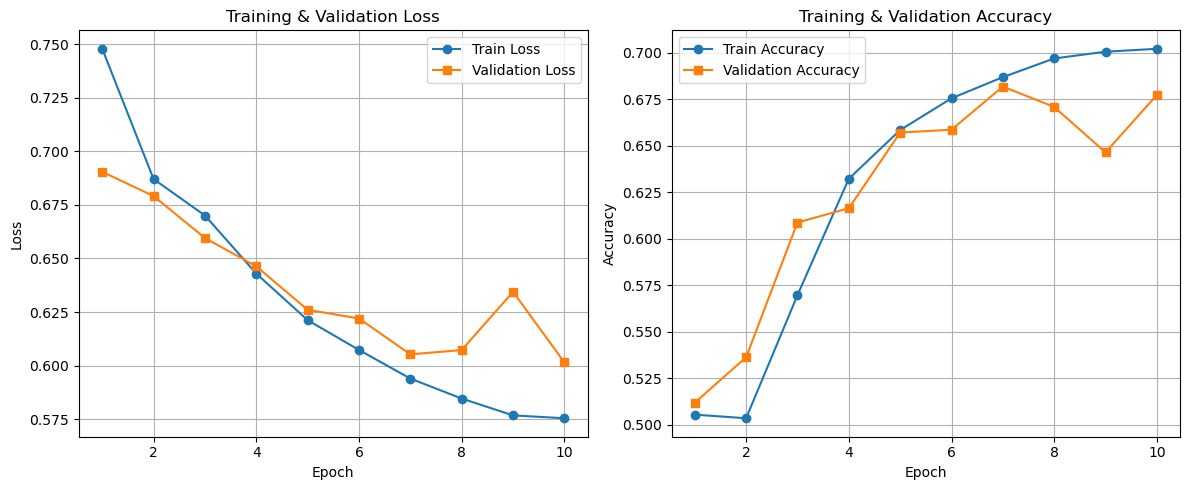

In [42]:
# YOUR CODE HERE

import numpy as np
import matplotlib.pyplot as plt


def plot_performance(train_losses, train_accs, val_losses, val_accs, offset):
    num_epochs = len(val_losses)
    
    # Averaging over the 
    epoch_train_losses = [sum(train_losses[i:i+offset]) / offset for i in range(0, len(train_losses), offset)]
    epoch_train_accs = [sum(train_accs[i:i+offset]) / offset for i in range(0, len(train_accs), offset)]
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_train_accs, label="Train Accuracy", marker="o")
    plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_performance(first_train_losses, first_train_accs, first_val_losses, first_val_accs, len(train_dataloader))

**(2 points)**

Based on these, what would you suggest for improving your model? Why?

**Your answer:** The dataset is not very big and the model clearly experiences overfitting quite early. A way to combat this is through regularization. Some methods include Dropout, which randomly drops neurons leading to a more robust model and kind of a trained ensemble of models. With dropout one must remember to put model.train() and model.eval() when performing training vs. validation. Another method is weight decay, providing a penalty on non-zero weights. And finally we implement batch normalization which also is said to have a regularizing effect by introducing noise into the optimization. 

The architecture is also improved, incorporating skipped-connections (á la ResNet) and a more modern deep architecture.

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights, optimizer state, losses and accuracies). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below.

In [40]:
# Assuming that you named your model "first_model" and training statistics as following
torch.save(
    {
        "model_state_dict": first_model.state_dict(),
        "train_losses": first_train_losses,
        "train_accs": first_train_accs,
        "val_losses": first_val_losses,
        "val_accs": first_val_accs,
    },
    "./first_model.ckpt",
)

# Example of creating and initialising model with a previously saved state dict:
saved_first_model = FirstCnn(img_size)  # fill-in the arguments if needed
checkpoint = torch.load("first_model.ckpt")
saved_first_model.load_state_dict(checkpoint["model_state_dict"])

# Example of re-using saved statistics:
print("Validation accuracies:", checkpoint["val_accs"])

NameError: name 'first_model' is not defined

---
## 3. Improving your model

**(3 points)**

Now you are free to create whichever model you want. A simple improvement based on your analysis of the above results is fine, or you can do something more ambitious. When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning. *Hint*: reducing the input image size facilitates training.

**NOTE**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of **one model**. Remove all code related to the models that were not chosen.

**NOTE 2**: It may feel like you are stuck trying to make the model perform better. Understanding the mechanics and a lot of experimentation will help gain intuition. But it is also beneficial for you to explore some of the popular architectures, building blocks, and techniques (e.g., residual blocks, Inception modules, dilated convolutions, depthwise separable convolutions, data augmentation etc).

In [22]:
# class ImprovedCnn...
#    def __init__...
#       ...
#    ...

# impr_model = ImprovedCnn(...
    
# YOUR CODE HERE

class Block(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            embed_dim, embed_dim, kernel_size=3, stride=1, padding=1,
            dilation=1, bias=False)
        self.bn1 = nn.BatchNorm2d(embed_dim)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            embed_dim, embed_dim, kernel_size=3, padding=1, dilation=1, bias=False)
        self.bn2 = nn.BatchNorm2d(embed_dim)
        self.act2 = nn.ReLU(inplace=True)

        self.drop_path = nn.Dropout(0.2)


    def forward(self, x):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Include dropout for regularization
        x = self.drop_path(x)

        # Residual connection
        x += shortcut
        x = self.act2(x)

        return x

class JohnWickCNN(nn.Module):
    # Some inspiration from https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/resnet.py#L354
    def __init__(self,
                depth=4,
                embed_dim=32,
                ):
        super().__init__()

        c_in = 3 
        self.conv1 = nn.Conv2d(c_in, embed_dim, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(embed_dim)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.blocks = nn.ModuleList([
            Block(embed_dim) for _ in range(depth)
        ])

        self.fc = nn.Linear(embed_dim, 1)

        self.final_act = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        # Residual blocks
        for blk in self.blocks:
            # Residual connection inside block (to get additional activation to be included for residual)
            x = blk(x)

        # Global average pooling
        x = x.mean([2,3])

        # Fully connected prediction
        x = self.fc(x)
        out = self.final_act(x)
        return out.squeeze(1)
            

model = JohnWickCNN()
model_new, train_losses_new, train_accs_new, val_losses_new, val_accs_new = training_loop(
    model=model,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.05),
    loss_fn=nn.BCELoss(),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=10,
    print_every=1,

)

Starting training
	Batch 1/625: 	Train loss: 0.822, 	Train acc.: 0.438, 	Val. loss: 0.704, 	Val. acc.: 0.498
	Batch 2/625: 	Train loss: 0.593, 	Train acc.: 0.656, 	Val. loss: 0.706, 	Val. acc.: 0.498


KeyboardInterrupt: 

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

In [ ]:
# YOUR CODE HERE
plot_performance(new_train_losses, new_train_accs, new_val_losses, new_val_accs, len(train_dataloader))

**(1 point)**

How does the model perform, compared to the first CNN model? Create one plot with the training accuracy and another with the validation accuracy of the two models.

In [ ]:
# YOUR CODE HERE

num_epochs = len(first_val_losses)
epoch_train_accs_first = [sum(first_train_accs[i:i+len(first_train_dataloader)]) / len(first_train_dataloader) for i in range(0, len(first_train_accs), len(first_train_dataloader))]
epoch_train_accs_new = [sum(new_train_accs[i:i+len(new_train_dataloader)]) / len(new_train_dataloader) for i in range(0, len(new_train_accs), len(new_train_dataloader))]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_train_accs_first, label="FirstCNN", marker="o")
plt.plot(range(1, num_epochs + 1), epoch_train_accs_new, label="John Wick CNN", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), first_val_accs, label="FirstCNN", marker="o")
plt.plot(range(1, num_epochs + 1), new_val_accs, label="JohnWickCNN", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**(1 point)**

Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** (fill in here)

Save your model to disk.

In [ ]:
# Assuming that you named your model and statistics as "impr_..."
torch.save(
    {
        "model_state_dict": impr_model.state_dict(),
        "train_losses": impr_train_losses,
        "train_accs": impr_train_accs,
        "val_losses": impr_val_losses,
        "val_accs": impr_val_accs,
    },
    "./improved_model.ckpt",
)

# YOUR CODE HERE

---
## 4. Transfer Learning

**From now, training on a CPU will likely not be feasible. If your computer has a GPU, try it out! Otherwise, now is the time to connect to a server/cloud instance**

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with our own top network, designed for dog/cat classification.
This top network is often called the "head" in transfer learning.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/vision/stable/models.html?highlight=vgg#torchvision.models.vgg16).

In [ ]:
from torchvision import models

vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# If you had to downgrade Python+torch+torchvision
# (i.e. your operating system does not support the provided environment file):
# the syntax for loading vgg16 weights is different in older version:
#     vgg_model = models.vgg16(pretrained=True)

print(vgg_model.classifier)

**(1 point)**

Create a new model named `head` as a so-called head network to the base VGG model.
VGG is a relatively deep network so think about what would be a reasonable model head for transfer learning.

*Hint:*
- You can access and modify the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [ ]:
head = None

# YOUR CODE HERE

In [ ]:
# Test case for `head`
ha1_tests.test_transfer_learning_head(head)

**(2 points)**

Now add the new model on top of VGG. You full model should be stored in the `vgg_model` variable.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Test case 1 for `vgg_model`
ha1_tests.test_vgg_model_1(vgg_model, head)

In [ ]:
# Test case 2 for `vgg_model`
ha1_tests.test_vgg_model_2(vgg_model, head)

### 4.1 Using VGG features

**(1 point)**

Now we're almost ready to train the new model. For transfer learning we want to freeze all but the top layers in your architecture (i.e. signal to the optimizer that the bottom layers should not be changed during optimization). We do that by setting the attribute `requires_grad` of every parameter in the feature sub-network of `vgg_model` to `False`.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Test case for `vgg_model`
ha1_tests.test_vgg_model_parameters_for_transfer_learning(vgg_model)

**(1 point)**

Prepare dataloaders for transfer learning. Don't forget that the VGG network is specialised for images of a certain size.

In [ ]:
train_dataloader = None
val_dataloader = None

# YOUR CODE HERE

In [ ]:
# Test case for `train_dataloader`
ha1_tests.test_dataloader_for_transfer_learning(train_dataloader)

In [ ]:
# Test case for `val_dataloader`
ha1_tests.test_dataloader_for_transfer_learning(val_dataloader)

**(1 point)**

Perform the transfer learning by training the top layers of your model.

In [ ]:
optimizer = None
num_epochs = None

# YOUR CODE HERE

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

In [ ]:
# YOUR CODE HERE

**(1 point)**

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

**(2 point)**

Compare these results.

- Which approach worked best, starting from scratch or doing transfer learning?
- Reflect on whether your comparison is fair or not.

**Your answer:** (fill in here)

**(2 points)**

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** (fill in here)

**(2 points)**

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** (fill in here)

**(1 points)**

In which scenario would transfer learning be unsuitable?

**Your answer:** (fill in here)

Save the model to a file.

In [ ]:
# YOUR CODE HERE

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers of `vgg_model` by resetting the `requires_grad` attribute to `True`.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Test case for `vgg_model`
ha1_tests.test_vgg_model_parameters_for_fine_tuning(vgg_model)

**(1 point)**

Fine tune the model by training all the layers.

In [ ]:
learning_rate = None
optimizer = None
num_epochs = None

# YOUR CODE HERE

In [ ]:
# Test case for `learning_rate`
ha1_tests.test_learning_rate(learning_rate)

**(1 point)**

How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

**(2 points)**

Why is it a good idea to use a very small learning rate when doing fine tuning?

**Your answer:** (fill in here)

Save the model to file.

In [ ]:
# YOUR CODE HERE

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [ ]:
# YOUR CODE HERE

**(1 point)**

How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios. A point is awarded if your improvement helped.

In [ ]:
# YOUR CODE HERE

Save the model to a file.

In [ ]:
# YOUR CODE HERE

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data loaders, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [ ]:
full_train_dataloader = None
full_val_dataloader = None

# YOUR CODE HERE

In [ ]:
# Test case for `full_train_dataloader` and `full_val_dataloader`
ha1_tests.test_dataloaders_for_final_training(full_train_dataloader, full_val_dataloader, verbose=False)

**(1 point)**

Train your model using the full data. This optimization might take a long time.

In [ ]:
learning_rate = None
optimizer = None
num_epochs = None

# YOUR CODE HERE

**(1 point)**

How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

**(2 points)**

- What can you conclude from these plots?
- Did you expect what you observe in the plots, explain!

**Your answer:** (fill in here)

Save the model to a file.

In [ ]:
# YOUR CODE HERE

## 6. Evaluation on test set (optional)

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labelled, so we can't compute any supervised performance metrics ourselves. 

As a bit of fun and to inspire some friendly competition you may instead submit it to Kaggle for evaluation.

**Feel free to experiment with different backbones and/or heads to create the best model you can.**

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

For the test data we need a slightly different dataset class, due to the lack of labels in the data.
A more proper way to implement it would be to make a common class which handles both the train and test settings.
Here, we'll just copy the train dataset class and make some modifications to ignore the labels.

Hints:
- There is a `sampleSubmission.csv` file included in the zip data. Take a look at it to better understand what is the expected format here.
- If you don't know how to create and write to files with Python, it's a well-behaved Google search.

In [ ]:
from pathlib import Path
from time import time


class TestData(Dataset):
    def __init__(self, root: Path, transform):
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self._samples = self._collect_samples()

    def __getitem__(self, index):
        path = self._samples[index]
        num_id = int(path.stem)
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, num_id

    def __len__(self):
        return len(self._samples)

    def _collect_samples(self):
        test_paths = self._collect_imgs_sub_dir(self.root)
        return sorted(list(test_paths), key=lambda path: int(path.stem))

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        if not sub_dir.exists():
            raise ValueError(f"Data root '{sub_dir}' does not exist.")
        return sub_dir.glob("*.jpg")

    def get_sample_by_id(self, id_):
        id_index = self._samples.index(id_)
        return self[id_index]


# YOUR CODE HERE

Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, but you can submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) via the "Late submission" button (they use the same data). The Kaggle CLI can be used as well. Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** (fill in here)

What was the username you used for this submission?

**Your answer:** (fill in here)